## Preparando o ambiente do colab

Esse notebook foi feito seguindo as instruções disponiveis no site da [Ultralytics](https://docs.ultralytics.com/pt/yolov5/tutorials/train_custom_data/).

> **AVISO:** Lembre-se de mudar o ambiente para GPU caso deseje realizar o treinamento da rede. Esqueci de fazer isso na primeira vez e levei 1 hora e meia para o treinamento, que depois foi feito em 25 minutos (com um dataset 12 vezes maior) ao realizar a troca.

Antes de rodar a célula abaixo, tenha certeza de ter feito o upload do arquivo dataset.zip que esta disponivel [aqui](https://github.com/luc-llb/challenges_BairesDev/tree/main/face_detection_test).



In [ ]:
!mkdir /content/dataset
!unzip /content/dataset.zip -d /content/dataset

In [2]:
!ls /content/dataset

data.yaml  images  labels


## Aumentando a quantidade de dados

Utilizaremos a técnica de *Data Argumentation* com o auxilio da biblioteca `albumentations` para cuidarmos dos *Bounding Box* enquanto alteramos as imagens.

In [ ]:
!pip install -U albumentations

In [4]:
import os
import cv2
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
import random
import shutil

# Diretórios
images_dir = "/content/dataset/images/train"
labels_dir = "/content/dataset/labels/train"

augmentation = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.GaussianBlur(p=0.2),
        A.HueSaturationValue(p=0.3),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

# Função para aplicar Data Augmentation
def augment_image(image_path, label_path, output_img_dir, output_lbl_dir, suffix='-1'):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(label_path, 'r') as f:
        labels = f.read().strip().split('\n')

    bboxes = []
    class_labels = []
    for label in labels:
        class_id, x, y, w, h = map(float, label.split())
        bboxes.append([x, y, w, h])
        class_labels.append(class_id)

    # Aplicar augmentations
    augmented = augmentation(image=img, bboxes=bboxes, class_labels=class_labels)
    augmented_img = augmented['image']
    augmented_bboxes = augmented['bboxes']
    augmented_class_labels = augmented['class_labels']

    # Modificar nomes dos arquivos para incluir o sufixo
    img_name = os.path.basename(image_path)
    label_name = os.path.basename(label_path)
    base_img_name, img_ext = os.path.splitext(img_name)
    base_label_name, label_ext = os.path.splitext(label_name)

    new_img_name = f"{base_img_name}{suffix}{img_ext}"
    new_label_name = f"{base_label_name}{suffix}{label_ext}"

    cv2.imwrite(os.path.join(output_img_dir, new_img_name), cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

    augmented_labels = []
    for bbox, class_id in zip(augmented_bboxes, augmented_class_labels):
        augmented_labels.append(f"{int(class_id)} {' '.join(map(str, bbox))}")

    with open(os.path.join(output_lbl_dir, new_label_name), 'w') as f:
        f.write("\n".join(augmented_labels))

# Aplicar Data Augmentation em todas as imagens
for image_name in os.listdir(images_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(images_dir, image_name)
        label_path = os.path.join(labels_dir, image_name.replace('.jpg', '.txt'))

        for i in range(5):
            suffix = f'-{i+1}'  # Criar sufixos únicos (-1, -2, -3, -4, -5)
            augment_image(image_path, label_path, images_dir, labels_dir, suffix)

print("Data Augmentation concluído!")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Data Augmentation concluído!


In [5]:
# Contando a nova quantidade de dados para o treinamento e comparando com a quantidade labels
!ls /content/dataset/images/train | wc -l
!ls /content/dataset/labels/train | wc -l

960
960


## Treinando a rede para detectar faces

In [ ]:
import torch

# Caminho para o repositório YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Instalar dependências
!pip install -r requirements.txt

Alterando uma linha do arquivo de treino para evitar warnings devido a depreciação do método `torch.cuda.amp.autocast()`

In [7]:
file_path = '/content/yolov5/train.py'

with open(file_path, 'r') as file:
    lines = file.readlines()

# Atualizar a linha com o método correto
lines = [line.replace("torch.cuda.amp.autocast(amp)", "torch.amp.autocast('cuda', enabled=amp)") for line in lines]

with open(file_path, 'w') as file:
    file.writelines(lines)

print("Arquivo train.py atualizado para corrigir o aviso!")


Arquivo train.py atualizado para corrigir o aviso!


Realizando o treinamento da rede:

In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/dataset/data.yaml --weights yolov5s.pt

Testando a rede:

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-1-18 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/c

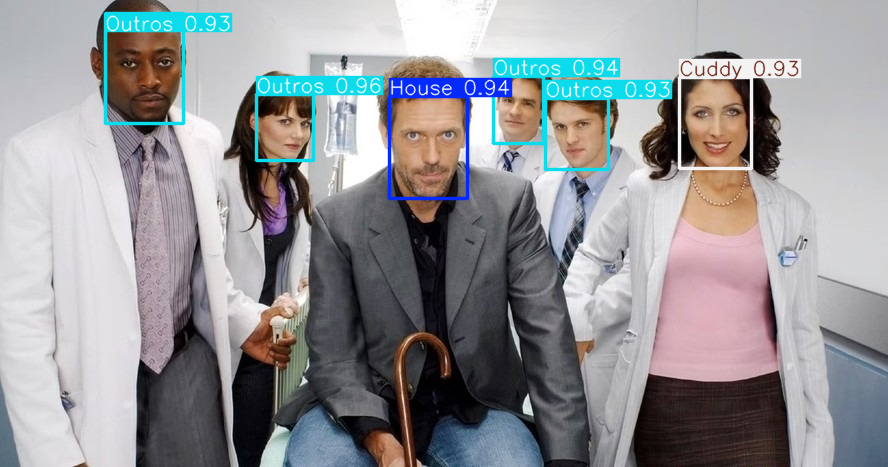

Saved 1 image to runs/detect/exp


In [9]:
# Caminho para os pesos treinados
weights_path = '/content/yolov5/runs/train/exp/weights/best.pt'

# Carregar modelo treinado
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path)

# Testar em uma imagem
img_path = '/content/teste.jpg'
results = model(img_path)
results.show()
results.save()

## Salvando o treinamento da rede no Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Diretório no Google Drive onde os pesos serão salvos
destination = '/content/drive/MyDrive/YOLOv5_Models/'

# Cria o diretório caso não exista
!mkdir -p {destination}

# Copia os arquivos de pesos para o Google Drive
!cp runs/train/exp/weights/best.pt {destination}
!cp runs/train/exp/weights/last.pt {destination}
